In [79]:
import os

os.environ["OMP_NUM_THREADS"] = '12'
import warnings

warnings.filterwarnings("ignore")

import torch
import torch.nn
import os.path as osp
import GCL.losses as L
import matplotlib.pyplot as plt
import GCL.augmentors as A
import numpy as np
import scipy.sparse as sp
import torch.nn.functional as F
import math

from torch import nn, tensor
from tqdm import tqdm
from torch.optim import Adam

from scipy.io import loadmat
from dgl.nn.pytorch import GATConv, GraphConv, GATv2Conv

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from munkres import Munkres, print_matrix
from sklearn import metrics
from GCL.models import DualBranchContrast, WithinEmbedContrast


In [80]:
import dgl
import dgl.function as fn
import dgl.nn.pytorch as dglnn
from dgl.utils import expand_as_pair


class GConv(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2):
        super(GConv, self).__init__()
        self.act = nn.ELU()
        self.num_layers = num_layers
        self.norm = nn.BatchNorm1d(input_dim)
        self.dropout = nn.Dropout(0.5)
        self.layers = nn.ModuleList()
        # self.layers.append(
        #     MyGATConv(in_feats=input_dim, out_feats=hidden_dim, allow_zero_in_degree=True, num_heads=num_heads,
        #               residual=False, feat_drop=0.5, attn_drop=0.5)
        # )
        # for _ in range(1, num_layers):
        #     self.layers.append(
        #         MyGATConv(in_feats=num_heads * hidden_dim, out_feats=hidden_dim, allow_zero_in_degree=True,
        #                   num_heads=num_heads, residual=False, feat_drop=0.5, attn_drop=0.5)
        #     )
        self.layers.append(
            GraphConv(in_feats=input_dim, out_feats=hidden_dim, allow_zero_in_degree=True, norm='left')
        )
        for _ in range(1, num_layers):
            self.layers.append(
                GraphConv(in_feats=hidden_dim, out_feats=hidden_dim, allow_zero_in_degree=True, norm='left')
            )
        self.register_buffer("epsilon", torch.FloatTensor([1e-12]))

    def forward(self, x, graph, edge_weight=None):
        z = x
        # attn = None
        # z = self.norm(z)

        for i in range(self.num_layers):
            # z, attn = self.layers[i](graph, z, attn)
            # z = self.layers[i](graph, z, edge_weight=edge_weight)
            # z = self.dropout(z)
            z = self.layers[i](graph, z)
            # z = z.flatten(1)
            z = self.act(z)
            # z = self.norm(z)

        # z = z / (torch.max(torch.norm(z, dim=1, keepdim=True), self.epsilon))
        # z = self.layers[-1](graph, z)
        # return F.normalize(z, dim=1)
        return z


class Encoder(nn.Module):
    def __init__(self, graph, augmentor, hidden_dim=256, proj_hidden_dim=128, n_clusters=3, num_layers=3):
        super(Encoder, self).__init__()

        self.encoder = GConv(input_dim=x.size(1), hidden_dim=hidden_dim, num_layers=num_layers).to(
            device)

        self.augmentor = augmentor
        self.register_buffer("epsilon", torch.FloatTensor([1e-12]))

        self.cluster_layer = nn.Parameter(torch.Tensor(n_clusters, hidden_dim))
        self.v = 1
        self.device = torch.device('cuda')
        torch.nn.init.xavier_normal_(self.cluster_layer.data)

        self.instance_projector = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, proj_hidden_dim),
        )

        self.cluster_projector = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ELU(),
            nn.Linear(hidden_dim, n_clusters),
            nn.Softmax(dim=1)
        )

    def forward(self, x, graph, edge_index, edge_weight=None):
        aug1, aug2 = self.augmentor
        z = self.encoder(x, graph)
        # z = self.decoder(z)

        x1, edge_index1, edge_weight1 = aug1(x, edge_index, edge_weight)
        #
        # x1, edge_index1, edge_weight1 = x, edge_index, edge_weight
        # for aug in aug1:
        #     x1, edge_index1, _ = aug.augment(x1, edge_index1, edge_weight1)
        graph1 = dgl.graph((edge_index1[0], edge_index1[1]), num_nodes=graph.num_nodes()).to(self.device)
        # graph1.remove_self_loop()
        graph1.add_self_loop()
        z1 = self.encoder(x1, graph1, edge_weight1)

        x2, edge_index2, edge_weight2 = aug2(x, edge_index, edge_weight)

        # x2, edge_index2, edge_weight2 = x, edge_index, edge_weight
        # for aug in aug2:
        #     x2, edge_index2, _ = aug.augment(x2, edge_index2, edge_weight2)
        graph2 = dgl.graph((edge_index2[0], edge_index2[1]), num_nodes=graph.num_nodes()).to(self.device)
        # graph2.remove_self_loop()
        graph2.add_self_loop()
        z2 = self.encoder(x2, graph2, edge_weight2)

        # c1 = F.normalize(self.cluster_projector(z1), dim=1)
        # c2 = F.normalize(self.cluster_projector(z2), dim=1)
        c1 = self.cluster_projector(z1)
        c2 = self.cluster_projector(z2)

        z1 = self.instance_projector(z1)
        z2 = self.instance_projector(z2)

        return z, z1, z2, c1, c2



In [81]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.t() / weight.sum(1)).t()



In [82]:

device = torch.device('cuda')
# path = osp.join(osp.pardir, 'datasets', 'DBLP')
#
# mat = loadmat(osp.join(path, 'DBLP4057_GAT_with_idx.mat'))
#
path = osp.join(osp.pardir, 'datasets', 'ACM')

mat = loadmat(osp.join(path, 'ACM3025.mat'))

# path = osp.join(osp.pardir, 'datasets', 'IMDB')
#
# mat = loadmat(osp.join(path, 'imdb5k.mat'))

print(mat.keys())


dict_keys(['__header__', '__version__', '__globals__', 'PAP', 'PLP', 'PMP', 'PTP', 'feature', 'label', 'test_idx', 'train_idx', 'val_idx'])


In [83]:
# print(mat['net_APCPA'])

In [84]:
# graph_dict = {}
# # for etype in ['net_APCPA']:
# for etype in ['PAP']:
#     # for etype in ['MDM']:
#     edge_index = []
#     for i in tqdm(range(len(mat[etype]))):
#         for j in range(len(mat[etype])):
#             if mat[etype][i][j] == 1:
#                 edge_index.append([i, j])
#     print(len(edge_index))
#     edge_index = tensor(edge_index, dtype=torch.long).t().contiguous()
#     graph = dgl.graph((edge_index[0], edge_index[1])).to(device)
#     graph.remove_self_loop()
#     graph.add_self_loop()
#
#     edge_index = torch.stack(graph.edges())
#     print(edge_index.size())

def load_graph(graph):
    n, _ = graph.shape

    # idx = np.array([i for i in range(n)], dtype=np.int32)
    # idx_map = {j: i for i, j in enumerate(idx)}
    # edges_unordered = data
    # edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
    #                  dtype=np.int32).reshape(edges_unordered.shape)
    edges = np.array(graph, dtype=np.int32)
    idx = edges.nonzero()  # (row, col)
    data = edges[idx]
    # adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
    #                     shape=(n, n), dtype=np.float32)
    adj = sp.coo_matrix((data, idx), shape=(n, n), dtype=np.float32)
    # build symmetric adjacency matrix
    # adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    # adj = adj + sp.eye(adj.shape[0])
    # adj = normalize(adj)
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    return adj


def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


adj = load_graph(mat['PAP']).to(device)
# print(np.load(osp.join(path, 'dblp_adj.npy')))
# adj = load_graph(np.load(osp.join(path, 'dblp_adj.npy'))).to(device)
graph = dgl.graph((adj._indices()[0], adj._indices()[1]), num_nodes=len(mat['PAP'])).to(device)
# graph = dgl.graph((adj._indices()[0], adj._indices()[1]), num_nodes=len(np.load(osp.join(path, 'dblp_adj.npy')))).to(device)
graph.remove_self_loop()
graph.add_self_loop()
edge_weight = adj._values()
edge_index = torch.stack(graph.edges())
print(graph)
print(adj)

Graph(num_nodes=3025, num_edges=29281,
      ndata_schemes={}
      edata_schemes={})
tensor(indices=tensor([[   0,    0,    0,  ..., 3024, 3024, 3024],
                       [   0,    8,   20,  ..., 2983, 2991, 3024]]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]),
       device='cuda:0', size=(3025, 3025), nnz=29281, layout=torch.sparse_coo)


In [85]:
x = tensor(mat['feature'], dtype=torch.float).to(device)
y = torch.argmax(tensor(mat['label']), -1).to(device)

# x = tensor(np.load(osp.join(path, 'dblp_feat.npy')), dtype=torch.float).to(device)
# y = tensor(np.load(osp.join(path, 'dblp_label.npy'))).to(device)
print(x.size())

torch.Size([3025, 1870])


In [86]:
del mat


model have 747423 paramerters in total


(T): 0it [00:00, ?it/s]
(T): 100%|███████████████| 500/500 [00:14<00:00, 34.73it/s, loss=6.95, con_loss=6.08, kl_loss=0.87]


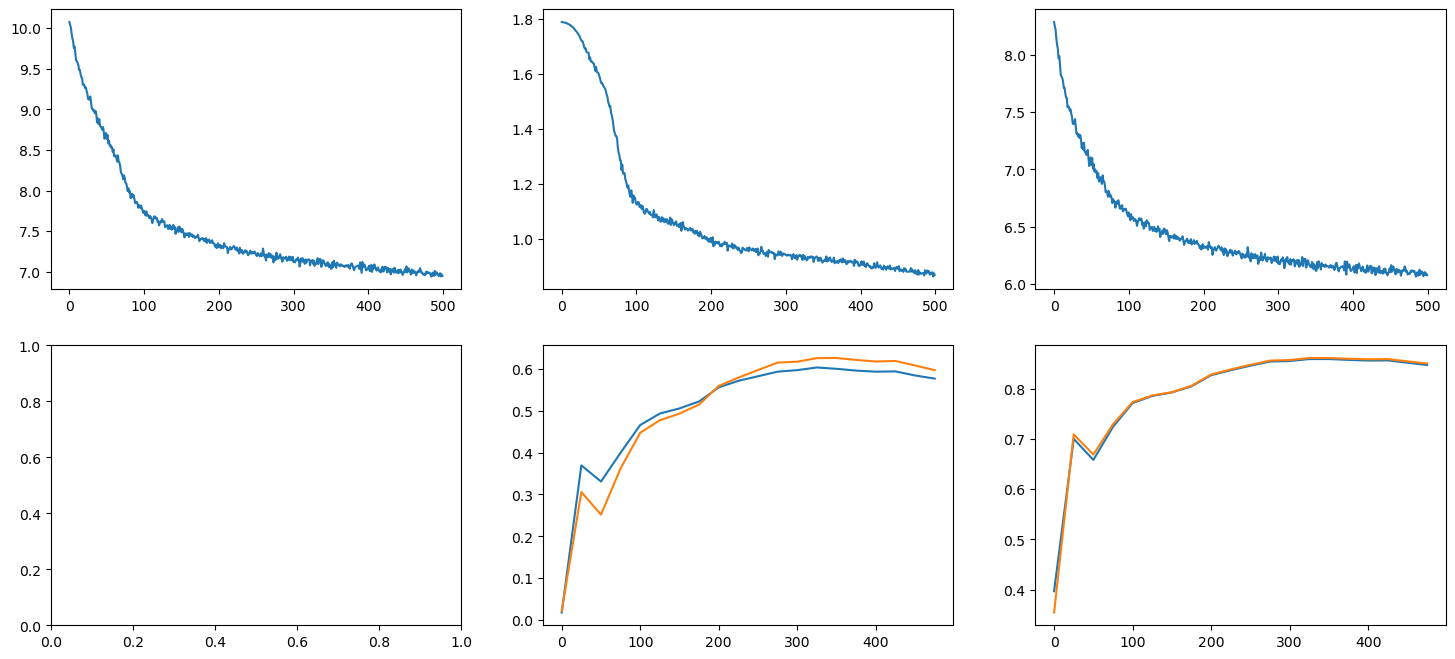

[MAX]ACC:  0.8588429752066116
[MAX]NMI:  0.6028938256018725
[MAX]ARI:  0.6255054282079608
[MAX]F1:  0.8609540552985786


In [91]:


def cluster_acc(y_true, y_pred):
    y_true = y_true - np.min(y_true)

    l1 = list(set(y_true))
    numclass1 = len(l1)

    l2 = list(set(y_pred))
    numclass2 = len(l2)

    ind = 0
    if numclass1 != numclass2:
        for i in l1:
            if i in l2:
                pass
            else:
                y_pred[ind] = i
                ind += 1

    l2 = list(set(y_pred))
    numclass2 = len(l2)

    if numclass1 != numclass2:
        print('error')
        return

    cost = np.zeros((numclass1, numclass2), dtype=int)
    for i, c1 in enumerate(l1):
        mps = [i1 for i1, e1 in enumerate(y_true) if e1 == c1]
        for j, c2 in enumerate(l2):
            mps_d = [i1 for i1 in mps if y_pred[i1] == c2]
            cost[i][j] = len(mps_d)

    # match two clustering results by Munkres algorithm
    m = Munkres()
    cost = cost.__neg__().tolist()
    indexes = m.compute(cost)

    # get the match results
    new_predict = np.zeros(len(y_pred))
    for i, c in enumerate(l1):
        # correponding label in l2:
        c2 = l2[indexes[i][1]]

        # ai is the index with label==c2 in the pred_label list
        ai = [ind for ind, elm in enumerate(y_pred) if elm == c2]
        new_predict[ai] = c

    acc = metrics.accuracy_score(y_true, new_predict)
    f1_macro = metrics.f1_score(y_true, new_predict, average='macro')
    precision_macro = metrics.precision_score(y_true, new_predict, average='macro')
    recall_macro = metrics.recall_score(y_true, new_predict, average='macro')
    f1_micro = metrics.f1_score(y_true, new_predict, average='micro')
    precision_micro = metrics.precision_score(y_true, new_predict, average='micro')
    recall_micro = metrics.recall_score(y_true, new_predict, average='micro')
    return acc, f1_macro


# def train(encoder_model, contrast_model, optimizer, x, graph, edge_index, clu_loss_func=ClusterLoss(class_num=4, temperature=1, device=device)):
def train1(encoder_model, contrast_model, optimizer, x, graph, edge_index, edge_weight,
           clu_loss_func=DualBranchContrast(loss=L.InfoNCE(tau=0.5), mode='L2L', intraview_negs=True).to(device)):
    encoder_model.train()
    optimizer.zero_grad()
    _, z1, z2, c1, c2 = encoder_model(x, graph, edge_index, edge_weight)
    con_loss = contrast_model(z1, z2)
    loss = con_loss
    # loss = con_loss

    loss.backward()
    optimizer.step()
    return loss.item(), con_loss.item()


def train2(encoder_model, contrast_model, optimizer, x, graph, edge_index, edge_weight,
           clu_loss_func):
    encoder_model.train()
    optimizer.zero_grad()
    _, z1, z2, c1, c2 = encoder_model(x, graph, edge_index, edge_weight)
    con_loss = contrast_model(z1, z2)
    # con_loss = F.mse_loss(torch.matmul(z1, z2.T), torch.eye(z1.size(0)).to('cuda'))

    clu_loss = clu_loss_func(c1.t(), c2.t())
    # clu_loss = clu_loss_func(c1.t(), c2.t())
    # clu_loss = 0.01 * contrast_model(c1.t(), c2.t())
    # con_loss = 0.01 * con_loss
    loss = con_loss + clu_loss
    # loss = con_loss + clu_loss

    loss.backward()
    optimizer.step()
    return loss.item(), con_loss.item(), clu_loss.item()


class EdgeRemoving:
    def __init__(self, pe: float, n_node: int):
        self.pe = pe
        self.n_node = n_node

    def augment(self, x, edge_index, edge_weights):
        row, col = edge_index
        mask = torch.rand(row.size(0), device=edge_index.device) >= self.pe
        row, col, edge_attr = row[mask], col[mask], None if edge_weights is None else edge_weights[mask]
        edge_index = torch.stack([row, col], dim=0)
        return x, edge_index, edge_weights


class FeatureDropout:
    def __init__(self, pf: float):
        self.pf = pf

    def augment(self, x, edge_index, edge_weights):
        x = F.dropout(x, p=1. - self.pf)
        return x, edge_index, edge_weights


class InfoNCE(nn.Module):
    def __init__(self, tau):
        super(InfoNCE, self).__init__()
        self.tau = tau

    def sim(self, z1, z2):
        # normalize embeddings across feature dimension
        z1 = F.normalize(z1)
        z2 = F.normalize(z2)

        s = torch.mm(z1, z2.t())
        return s

    def get_loss(self, z1, z2):
        # calculate SimCLR loss
        f = lambda x: torch.exp(x / self.tau)

        refl_sim = f(self.sim(z1, z1))  # intra-view pairs
        between_sim = f(self.sim(z1, z2))  # inter-view pairs

        # between_sim.diag(): positive pairs
        x1 = refl_sim.sum(1) + between_sim.sum(1) - refl_sim.diag()
        loss = -torch.log(between_sim.diag() / x1)

        return loss.mean()

    def forward(self, z1, z2):
        l1 = self.get_loss(z1, z2)
        l2 = self.get_loss(z2, z1)

        ret = (l1 + l2) * 0.5

        # return ret.mean()
        return ret


# aug1 = (EdgeRemoving(pe=0.5, n_node=x.size(0)), FeatureDropout(pf=0.5))
# aug2 = (EdgeRemoving(pe=0.5, n_node=x.size(0)), FeatureDropout(pf=0.5))
# aug1 = (FeatureDropout(pf=0.7),)
# aug2 = (FeatureDropout(pf=0.7),)
aug1 = A.Compose([A.EdgeRemoving(pe=0.5), A.FeatureDropout(pf=0.5)])
# aug1 = A.Identity()
aug2 = A.Compose([A.EdgeRemoving(pe=0.5), A.FeatureDropout(pf=0.5)])
# aug1 = A.Compose([A.MarkovDiffusion()])
# aug2 = A.Compose([A.MarkovDiffusion()])
# encoder_model = Encoder(graph=graph, augmentor=(aug1, aug2), hidden_dim=32, num_heads=4, n_clusters=4, num_layers=2).to(device)
encoder_model = Encoder(graph=graph, augmentor=(aug1, aug2), hidden_dim=256, proj_hidden_dim=256, n_clusters=3,
                        num_layers=2).to(device)

print("model have {} paramerters in total".format(sum(x.numel() for x in encoder_model.parameters())))

# contrast_model = WithinEmbedContrast(loss=L.BarlowTwins()).to(device)
contrast_model = DualBranchContrast(loss=L.InfoNCE(tau=0.2), mode='L2L', intraview_negs=True).to(device)
cluster__model = DualBranchContrast(loss=L.InfoNCE(tau=0.2), mode='L2L', intraview_negs=True).to(device)
# contrast_model = nn.MSELoss()
# contrast_model = WithinEmbedContrast(loss=L.VICReg()).to(device)
# contrast_model = InfoNCE(tau=0.2).to(device)
# cluster__model = InfoNCE(tau=0.2).to(device)

# optimizer = Adam(encoder_model.parameters(), lr=5e-4)
optimizer1 = Adam(encoder_model.parameters(), lr=0.0001, weight_decay=1e-5)
optimizer = Adam(encoder_model.parameters(), lr=0.0001, weight_decay=1e-5)
losss = []
kl_losss = []
con_losss = []
nmis = []
aris = []
ratios = []
accs = []
f1s = []
epochs1 = 0
epochs2 = 500

kmeans = KMeans(n_clusters=3, n_init=16)

with tqdm(total=epochs1, desc='(T)') as pbar:
    for epoch in range(epochs1):
        encoder_model.train()
        # if epoch % 1 == 0:
        #     # update_interval
        #     _, _, _, tmp_q = encoder_model(x, graph, edge_index)
        #
        #     p = target_distribution(tmp_q.data)

        loss, con_loss = train1(encoder_model, contrast_model,
                                optimizer1, x, graph, edge_index,
                                edge_weight)
        pbar.set_postfix({'loss': loss, 'con_loss': con_loss})
        pbar.update()

with tqdm(total=epochs2, desc='(T)') as pbar:
    for epoch in range(epochs2):
        encoder_model.train()
        # if epoch % 1 == 0:
        #     # update_interval
        #     _, _, _, tmp_q = encoder_model(x, graph, edge_index)
        #
        #     p = target_distribution(tmp_q.data)

        loss, con_loss, kl_loss = train2(encoder_model, contrast_model, optimizer, x, graph, edge_index, edge_weight,
                                         clu_loss_func=cluster__model)
        pbar.set_postfix({'loss': loss, 'con_loss': con_loss, 'kl_loss': kl_loss})
        pbar.update()
        losss.append(loss)
        kl_losss.append(kl_loss)
        con_losss.append(con_loss)
        ratios.append((100 * kl_loss) / loss)

        if epoch % 25 == 0:
            with torch.no_grad():
                encoder_model.eval()
                z, _, _, _, _ = encoder_model(x, graph, edge_index, edge_weight)
            pred = kmeans.fit_predict(z.cpu())
            nmi = normalized_mutual_info_score(pred, y.cpu())
            ari = adjusted_rand_score(pred, y.cpu())
            nmis.append((epoch, nmi))
            aris.append((epoch, ari))

            acc, f1 = cluster_acc(y.cpu().numpy(), pred)

            accs.append((epoch, acc))
            f1s.append((epoch, f1))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8))
axes[0][0].plot(range(epochs2), losss)
axes[0][1].plot(range(epochs2), kl_losss)
axes[0][2].plot(range(epochs2), con_losss)
axes[1][1].plot([i[0] for i in nmis], [i[1] for i in nmis])
axes[1][1].plot([i[0] for i in aris], [i[1] for i in aris])
axes[1][2].plot([i[0] for i in aris], [i[1] for i in accs])
axes[1][2].plot([i[0] for i in aris], [i[1] for i in f1s])
plt.show()
print('[MAX]ACC: ', max([i[1] for i in accs]))
print('[MAX]NMI: ', max([i[1] for i in nmis]))
print('[MAX]ARI: ', max([i[1] for i in aris]))
print('[MAX]F1: ', max([i[1] for i in f1s]))
# test_result = test(encoder_model, data)
# print(f'(E): Best test F1Mi={test_result["micro_f1"]:.4f}, F1Ma={test_result["macro_f1"]:.4f}')


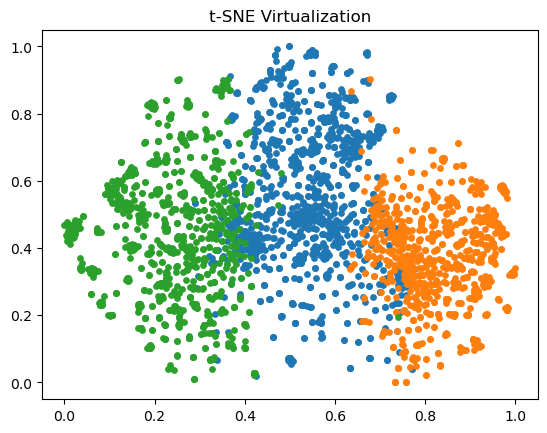

In [92]:
from sklearn import manifold, datasets

tsne = manifold.TSNE(n_components=2, init='pca')

with torch.no_grad():
    encoder_model.eval()
    z, _, _, _, _ = encoder_model(x, graph, edge_index, edge_weight)
    pred = kmeans.fit_predict(z.cpu())
X_tsne = tsne.fit_transform(z.cpu().numpy())
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)

d = np.where(pred == 0)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 1)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 2)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 3)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)

plt.title('t-SNE Virtualization')
plt.show()

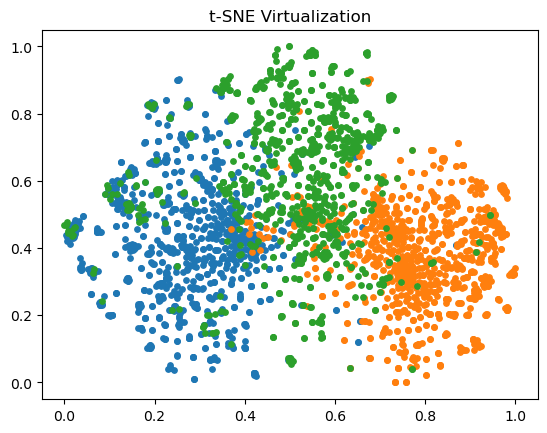

In [93]:
d = np.where(y.cpu() == 0)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(y.cpu() == 1)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(y.cpu() == 2)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(y.cpu() == 3)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)

plt.title('t-SNE Virtualization')
plt.show()

In [94]:

with torch.no_grad():
    encoder_model.eval()
    z, _, _, qs = encoder_model(x, graph, edge_index)

pred = kmeans.fit_predict(z.cpu())

nmi = normalized_mutual_info_score(pred, y.cpu())
print('[INFO]NMI: ', nmi)

ari = adjusted_rand_score(pred, y.cpu())
print('[INFO]ARI: ', ari)



ValueError: too many values to unpack (expected 4)

In [ ]:

pred = kmeans.fit_predict(x.cpu())

nmi = normalized_mutual_info_score(pred, y.cpu())
print('[INFO]NMI: ', nmi)

ari = adjusted_rand_score(pred, y.cpu())
print('[INFO]ARI: ', ari)

In [ ]:


with torch.no_grad():
    encoder_model.eval()
    z, _, _, _ = encoder_model(x, graph_dict)

pred = kmeans.fit_predict(z.cpu())
acc, f1 = cluster_acc(y.cpu().numpy(), pred)
print(acc, f1)